# TESS Data Exploration and Transit Detection

This notebook explores light curve data from the TESS mission and applies machine learning methods to detect exoplanet transits.

## Debugging Note
If you're having trouble with file paths or no FITS files being processed, run all cells in order. The notebook has been updated to:
1. Try multiple path patterns to locate FITS files
2. Display detailed error messages to help diagnose issues
3. Verify data directory structure

In [1]:
from astropy.io import fits
from astropy.timeseries import TimeSeries, LombScargle
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import pandas as pd
import glob
import os
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astroquery.mast import Observations
import astropy.units as u
import lightkurve as lk

# Add the project root to sys.path to import shared modules
import sys
sys.path.append("../..")

c:\Users\Pablo\OneDrive\School of life\Coding\Codigo\Python\practice1\.venv\Lib\site-packages\lightkurve\prf\__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [2]:
# Optional: Search and download TESS data for a specific target
# search = lk.search_lightcurve("TIC 307210830", mission="TESS")
# print(search)

# lc_collection = search.download_all(download_dir="../data/raw/")
# combined_lc = lc_collection.stitch().normalize()
# combined_lc.plot()

In [3]:
# Check actual data directory structure to help debug path issues
import os

def print_directory_tree(path, level=0, max_level=4, max_files=5):
    """Print a simplified directory tree to help debug path issues"""
    if level > max_level:
        print('  ' * level + '...')
        return
        
    if not os.path.exists(path):
        print(f"Directory does not exist: {path}")
        return
        
    print('  ' * level + os.path.basename(path) + '/')
    
    try:
        items = os.listdir(path)
        dirs = [item for item in items if os.path.isdir(os.path.join(path, item))]
        files = [item for item in items if os.path.isfile(os.path.join(path, item))]
        
        # Print directories first
        for d in dirs:
            print_directory_tree(os.path.join(path, d), level + 1, max_level, max_files)
            
        # Print a sample of files
        if files:
            if len(files) <= max_files:
                for f in files:
                    print('  ' * (level + 1) + f)
            else:
                for f in files[:max_files]:
                    print('  ' * (level + 1) + f)
                print('  ' * (level + 1) + f'... ({len(files) - max_files} more files)')
    except Exception as e:
        print('  ' * (level + 1) + f'Error: {str(e)}')

# Check project root data directory and multiple levels up
print("Checking data directory structure with expanded search:")
data_paths = [
    "../data",
    "../../data", 
    "../../../data",
    "../data/TESS",
    "../data/raw",
    "../../data/raw",
    "../../../data/raw",
    "../../data/raw/mastDownload",
    os.path.abspath("../data"),
    os.path.abspath("../../data"),
    os.path.abspath("../../../data")
]

# Record all found FITS files to avoid duplicates
all_fits_files = set()

for path in data_paths:
    print(f"\nChecking path: {path}")
    print_directory_tree(path)
    
# Check if FITS files exist in any of these locations
fits_count = 0
for path in data_paths:
    if os.path.exists(path):
        for root, dirs, files in os.walk(path):
            fits_files = [f for f in files if f.endswith('.fits')]
            local_count = 0
            
            for f in fits_files:
                full_path = os.path.join(root, f)
                if full_path not in all_fits_files:
                    all_fits_files.add(full_path)
                    local_count += 1
            
            if local_count > 0:
                print(f"\nFound {local_count} unique FITS files in {root}")
                # Show a few examples from this directory
                shown = 0
                for f in fits_files:
                    full_path = os.path.join(root, f)
                    if shown < 3:  
                        print(f"  {full_path}")
                        shown += 1
                
                if local_count > 3:
                    print(f"  ... and {local_count - 3} more")
                    
print(f"\nTotal unique FITS files found: {len(all_fits_files)}")

# Save all paths to a list for later use
fits_file_paths = list(all_fits_files)

Checking data directory structure with expanded search:

Checking path: ../data
data/
  processed/
    combined_transit_features.csv
    transit_features.csv
  raw/
    mastDownload/
      HLSP/
        hlsp_qlp_tess_ffi_s0002-0000000307210830_tess_v01_llc/
          hlsp_qlp_tess_ffi_s0002-0000000307210830_tess_v01_llc.fits
        hlsp_qlp_tess_ffi_s0005-0000000307210830_tess_v01_llc/
          hlsp_qlp_tess_ffi_s0005-0000000307210830_tess_v01_llc.fits
        hlsp_qlp_tess_ffi_s0008-0000000307210830_tess_v01_llc/
          hlsp_qlp_tess_ffi_s0008-0000000307210830_tess_v01_llc.fits
        hlsp_qlp_tess_ffi_s0009-0000000307210830_tess_v01_llc/
          hlsp_qlp_tess_ffi_s0009-0000000307210830_tess_v01_llc.fits
        hlsp_qlp_tess_ffi_s0010-0000000307210830_tess_v01_llc/
          hlsp_qlp_tess_ffi_s0010-0000000307210830_tess_v01_llc.fits
        hlsp_qlp_tess_ffi_s0011-0000000307210830_tess_v01_llc/
          hlsp_qlp_tess_ffi_s0011-0000000307210830_tess_v01_llc.fits
        hlsp_

In [4]:
# Collect all FITS files in both HLSP and TESS folders
# Let's try different path patterns to find the files
path_patterns = [
        "../data/raw/mastDownload/**/**/*.fits",
]

# Try all patterns and collect unique files
all_fits_files = set()
for pattern in path_patterns:
    files_found = glob.glob(pattern, recursive=True)
    if files_found:
        print(f"Pattern '{pattern}': Found {len(files_found)} FITS files")
        
        # Add to our set of unique files
        for file in files_found:
            all_fits_files.add(os.path.abspath(file))

# Convert to list for further processing
fits_files = list(all_fits_files)
print(f"\nTotal unique FITS files found across all patterns: {len(fits_files)}")

if fits_files:
    print("\nFirst few files:")
    for file in fits_files[:5]:
        print(f"  {file}")
    
    # Check if we have FITS files with different flux column names
    pdcsap_count = 0
    flux_count = 0
    sap_count = 0
    
    for file in fits_files[:20]:  # Check first 20 files
        try:
            with fits.open(file) as hdul:
                if 'PDCSAP_FLUX' in hdul[1].data.names:
                    pdcsap_count += 1
                if 'SAP_FLUX' in hdul[1].data.names:
                    sap_count += 1
                if 'FLUX' in hdul[1].data.names and 'PDCSAP_FLUX' not in hdul[1].data.names:
                    flux_count += 1
        except Exception as e:
            print(f"Error checking {file}: {str(e)}")
    
    print(f"\nFlux column types in sample:")
    print(f"  PDCSAP_FLUX: {pdcsap_count} files")
    print(f"  SAP_FLUX: {sap_count} files")
    print(f"  FLUX only: {flux_count} files")
    
else:
    print("No FITS files found. Please check the data directory structure.")

Pattern '../data/raw/mastDownload/**/**/*.fits': Found 273 FITS files

Total unique FITS files found across all patterns: 91

First few files:
  c:\Users\Pablo\OneDrive\School of life\Coding\Codigo\Python\practice1\projects\exoplanet-transit-detection\data\raw\mastDownload\HLSP\hlsp_tess-spoc_tess_phot_0000000307210830-s0036_tess_v1_tp\hlsp_tess-spoc_tess_phot_0000000307210830-s0036_tess_v1_lc.fits
  c:\Users\Pablo\OneDrive\School of life\Coding\Codigo\Python\practice1\projects\exoplanet-transit-detection\data\raw\mastDownload\HLSP\hlsp_qlp_tess_ffi_s0009-0000000307210830_tess_v01_llc\hlsp_qlp_tess_ffi_s0009-0000000307210830_tess_v01_llc.fits
  c:\Users\Pablo\OneDrive\School of life\Coding\Codigo\Python\practice1\projects\exoplanet-transit-detection\data\raw\mastDownload\HLSP\hlsp_qlp_tess_ffi_s0037-0000000307210830_tess_v01_llc\hlsp_qlp_tess_ffi_s0037-0000000307210830_tess_v01_llc.fits
  c:\Users\Pablo\OneDrive\School of life\Coding\Codigo\Python\practice1\projects\exoplanet-transit-d

In [5]:
def period_features(time, flux):
    """Extract period-related features using Lomb-Scargle periodogram."""
    try:
        # Ensure we have enough data points
        if len(time) < 10:
            return 0, 0
            
        # Handle any NaN values
        valid_mask = ~np.isnan(time) & ~np.isnan(flux)
        if np.sum(valid_mask) < 10:
            return 0, 0
            
        time_valid = time[valid_mask]
        flux_valid = flux[valid_mask]
        
        # Run Lomb-Scargle
        ls = LombScargle(time_valid, flux_valid)
        freq, power = ls.autopower()
        
        # Check if we got valid results
        if len(freq) == 0 or np.all(np.isnan(power)):
            return 0, 0
            
        best_period = 1 / freq[np.argmax(power)]
        best_power = np.max(power)
        
        # Sanity check the period (sometimes we get unrealistic values)
        if best_period < 0.1 or best_period > 100:
            return 0, 0
            
        return best_period, best_power
    except Exception:
        return 0, 0

In [6]:
def shape_features(local_flux):
    if len(local_flux) < 3:
        return 0, 0, 0
    depth = 1.0 - np.min(local_flux)
    width = np.sum(local_flux < (1 - depth/2))  # number of points below half-depth
    # symmetry: compare first half vs second half of dip
    symmetry = np.corrcoef(local_flux[:len(local_flux)//2],
                            local_flux[len(local_flux)//2:])[0, 1] if len(local_flux) > 4 else 0
    return depth, width, symmetry

In [7]:
# Import the shared module for flux loading
from shared.data_utils import load_flux_from_fits, normalize_flux

def extract_features_from_file(path, threshold_percentile=5, flux_column='PDCSAP_FLUX'):  # Added flux_column parameter
    try:
        # Use our shared utility to load the flux data with flexible column handling
        time, flux, quality, flux_column_used = load_flux_from_fits(
            path, 
            flux_columns=[flux_column, 'PDCSAP_FLUX', 'SAP_FLUX', 'FLUX']
        )
        
        if time is None or flux is None:
            return [], [], []
            
        # Normalize the flux
        flux_norm = normalize_flux(flux)
        
        # Calculate period features once for the entire lightcurve
        best_period, best_power = period_features(time, flux_norm)
        
        # Find dips using percentile threshold - increased to 5%
        threshold = np.percentile(flux_norm, threshold_percentile)
        dip_mask = flux_norm < threshold
        dip_indices = np.where(dip_mask)[0]
        
        features, labels = [], []
        
        # Process transit candidates (dips)
        for idx in dip_indices:
            # Extract a window around the dip
            window_start = max(0, idx-20)
            window_end = min(len(flux_norm), idx+20)
            local_flux = flux_norm[window_start:window_end]
            local_time = time[window_start:window_end]
            
            # Calculate shape features
            depth, width, symmetry = shape_features(local_flux)
            
            # Calculate additional features
            local_slope = np.polyfit(range(len(local_flux)), local_flux, 1)[0]
            local_std = np.std(local_flux)
            window_ratio = np.mean(local_flux) / np.mean(flux_norm)
            snr = depth / (local_std + 1e-6)
            
            # Relaxed criteria for transit identification
            is_likely_transit = (width > 2 and 
                               symmetry > 0.3 and  # Relaxed from 0.6
                               snr > 3 and         # Relaxed from 7
                               local_slope < 0.02) # Relaxed from 0.01            
            features.append([
                local_std, width, symmetry, local_slope,
                window_ratio, snr, best_power
            ])
            labels.append(1 if is_likely_transit else 0)
        
        # Add non-transit baseline samples
        if len(dip_indices) > 0:
            non_dip_mask = ~dip_mask
            normal_indices = np.random.choice(
                np.where(non_dip_mask)[0],
                min(len(dip_indices), sum(non_dip_mask)),
                replace=False
            )
            
            for idx in normal_indices:
                window_start = max(0, idx-20)
                window_end = min(len(flux_norm), idx+20)
                local_flux = flux_norm[window_start:window_end]
                
                depth, width, symmetry = shape_features(local_flux)
                local_std = np.std(local_flux)
                local_slope = np.polyfit(range(len(local_flux)), local_flux, 1)[0]
                window_ratio = np.mean(local_flux) / np.mean(flux_norm)
                snr = depth / (local_std + 1e-6)
                
                features.append([
                    local_std, width, symmetry, local_slope,
                    window_ratio, snr, best_power
                ])
                labels.append(0)  # Definitely not a transit
                
        # Add source file as metadata
        return features, labels, [path] * len(features)

    except Exception as e:
        # Now with error printing for debugging
        print(f"Error processing {path}: {str(e)}")
        return [], [], []

ModuleNotFoundError: No module named 'shared'

## Processing FITS Files

If the previous cell shows that FITS files are found but this cell doesn't process any successfully, there might be issues with:

1. **File paths**: The glob pattern might not be matching your files
2. **File structure**: The FITS files might not have the expected structure
3. **Flux column names**: Your files might use different column names than expected

The updated code below tries multiple path patterns and provides more detailed error information.

In [ ]:
all_features, all_labels, all_sources = [], [], []
successful_files = 0
error_files = 0

# Specify which flux column to use ('PDCSAP_FLUX', 'SAP_FLUX', or 'FLUX')
flux_column = 'PDCSAP_FLUX'  # You can change this to 'FLUX' if needed

# If we have the fits_files from the previous cell, use them directly
if 'fits_files' in locals() and fits_files:
    files_to_process = fits_files
else:
    # Otherwise use comprehensive path patterns
    path_patterns = [
        "../data/raw/mastDownload/**/**/*.fits",
    ]
    
    # Collect all unique files
    all_found_files = set()
    for pattern in path_patterns:
        files_found = glob.glob(pattern, recursive=True)
        print(f"Searching with pattern: {pattern}")
        print(f"Found {len(files_found)} files with pattern {pattern}")
        
        for file in files_found:
            all_found_files.add(os.path.abspath(file))
    
    files_to_process = list(all_found_files)
    print(f"Total unique files to process: {len(files_to_process)}")

# Use a try-except block around the loop to catch all errors
try:
    print(f"Processing {len(files_to_process)} FITS files...")
    for path in files_to_process:
        try:
            feats, labels, sources = extract_features_from_file(
                path, 
                threshold_percentile=5,
                flux_column=flux_column
            )
            if feats:  # Only add if we got some features
                all_features.extend(feats)
                all_labels.extend(labels)
                all_sources.extend(sources)
                successful_files += 1
                if successful_files % 10 == 0:
                    print(f"Successfully processed {successful_files} files so far")
        except Exception as e:
            # Count errors but now print the actual error for debugging
            print(f"Error processing {path}: {str(e)}")
            error_files += 1
            continue
except Exception as e:
    print(f"Global error: {str(e)}")

print(f"Processed FITS files: {successful_files} successful, {error_files} with errors")
print(f"Used flux column: {flux_column}")

if all_features:
    df = pd.DataFrame(all_features, columns=[
        "local_noise", "width", "symmetry", "local_slope",
        "window_ratio", "snr", "best_power"
    ])
    df["label"] = all_labels
    df["source_file"] = all_sources

    # Print label distribution to verify we have both classes
    print("Label distribution:", df.label.value_counts())
    
    # Count unique source files that produced features
    unique_sources = len(set(all_sources))
    print(f"Features extracted from {unique_sources} unique FITS files")
else:
    print("No features extracted from any files. Check file paths and data structure.")

Processing 91 FITS files...
Error processing c:\Users\Pablo\OneDrive\School of life\Coding\Codigo\Python\practice1\projects\exoplanet-transit-detection\data\raw\mastDownload\HLSP\hlsp_qlp_tess_ffi_s0088-0000000307210830_tess_v01_llc\hlsp_qlp_tess_ffi_s0088-0000000307210830_tess_v01_llc.fits: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 15 and the array at index 1 has size 16
Error loading c:\Users\Pablo\OneDrive\School of life\Coding\Codigo\Python\practice1\projects\exoplanet-transit-detection\data\raw\mastDownload\HLSP\hlsp_tasoc_tess_tpf_tic00307210830-s0002-cam4-ccd3-c0120_tess_v05\hlsp_tasoc_tess_tpf_tic00307210830-s0002-cam4-ccd3-c0120_tess_v05_cbv-lc.fits: [Errno 22] Invalid argument
Error processing c:\Users\Pablo\OneDrive\School of life\Coding\Codigo\Python\practice1\projects\exoplanet-transit-detection\data\raw\mastDownload\HLSP\hlsp_qlp_tess_ffi_s0088-0000000307210830_tess_v01_llc\hls

# Handling Different Flux Columns

Some FITS files use 'PDCSAP_FLUX' while others use just 'FLUX'. Let's run the processing with both column types and combine the results.

In [ ]:
def process_with_multiple_flux_columns(flux_columns=['PDCSAP_FLUX', 'FLUX'], threshold_percentile=5):
    """
    Process all FITS files with multiple flux column options and combine the results.
    
    Args:
        flux_columns (list): List of flux column names to try
        threshold_percentile (float): Percentile threshold for identifying transit candidates
        
    Returns:
        DataFrame: Combined dataset with features from all successfully processed files
    """
    all_features, all_labels, all_sources = [], [], []
    results_by_column = {}
    
    # Get the files to process - either from previous cells or by searching again
    if 'fits_files' in globals() and fits_files:
        files_to_process = fits_files
        print(f"Using {len(files_to_process)} previously found FITS files")
    elif 'fits_file_paths' in globals() and fits_file_paths:
        files_to_process = fits_file_paths
        print(f"Using {len(files_to_process)} previously found FITS files from directory scan")
    else:
        # Define comprehensive file path patterns
        path_patterns = [
            "../data/**/*.fits",
            "../data/**/**/*.fits", 
            "../data/**/**/**/*.fits",
            "../../data/**/*.fits",
            "../../data/**/**/*.fits",
            "../../data/**/**/**/*.fits",
            "../../../data/**/*.fits",
            "../../../data/**/**/*.fits",
            "../../../data/**/**/**/*.fits",
            "../data/raw/mastDownload/**/**/*.fits",
            "../data/TESS/**/**/*.fits"
        ]
        
        # Find all unique files
        unique_files = set()
        for pattern in path_patterns:
            found = glob.glob(pattern, recursive=True)
            if found:
                print(f"Pattern '{pattern}' found {len(found)} files")
                for file in found:
                    unique_files.add(os.path.abspath(file))
        
        if not unique_files:
            print("No FITS files found with any pattern. Check data directory.")
            return None
            
        files_to_process = list(unique_files)
        print(f"Found {len(files_to_process)} unique FITS files to process")
    
    # Process each flux column type
    for flux_column in flux_columns:
        print(f"\nProcessing files with flux column: {flux_column}")
        features, labels, sources = [], [], []
        successful_files = 0
        error_files = 0
        
        # Use a try-except block around the loop to catch all errors
        try:
            for path in files_to_process:
                try:
                    feats, labs, src = extract_features_from_file(
                        path, 
                        threshold_percentile=threshold_percentile,
                        flux_column=flux_column
                    )
                    if feats:  # Only add if we got some features
                        features.extend(feats)
                        labels.extend(labs)
                        sources.extend(src)
                        successful_files += 1
                        if successful_files % 10 == 0:
                            print(f"Successfully processed {successful_files} files with {flux_column}")
                except Exception as e:
                    # Count errors and print the error for debugging
                    print(f"Error processing {path} with {flux_column}: {str(e)}")
                    error_files += 1
                    continue
        except Exception as e:
            print(f"Global error with {flux_column}: {str(e)}")
        
        print(f"Processed FITS files with {flux_column}: {successful_files} successful, {error_files} with errors")
        
        # Store results for this flux column
        results_by_column[flux_column] = {
            'features': features,
            'labels': labels,
            'sources': sources,
            'successful_files': successful_files
        }
        
        # Add to the combined results
        all_features.extend(features)
        all_labels.extend(labels)
        all_sources.extend(sources)
    
    # Create a combined DataFrame
    if all_features:
        df = pd.DataFrame(all_features, columns=[
            "local_noise", "width", "symmetry", "local_slope",
            "window_ratio", "snr", "best_power"
        ])
        df["label"] = all_labels
        df["source_file"] = all_sources
        
        # Print summary statistics
        print("\n--- Combined Results Summary ---")
        print(f"Total samples: {len(df)}")
        print("Label distribution:", df.label.value_counts())
        
        # Print results by flux column
        print("\nResults by flux column:")
        for flux_column, results in results_by_column.items():
            n_samples = len(results['features'])
            n_positives = sum(results['labels'])
            if n_samples > 0:
                print(f"{flux_column}: {n_samples} samples, {n_positives} transits ({n_positives/n_samples:.1%})")
            else:
                print(f"{flux_column}: No samples found")
        
        # Count unique source files
        unique_sources = len(set(all_sources))
        print(f"\nFeatures extracted from {unique_sources} unique FITS files out of {len(files_to_process)} total files")
        
        return df
    else:
        print("No valid data found in any flux column.")
        return None

In [ ]:
# Process files with both flux column types
combined_df = process_with_multiple_flux_columns(
    flux_columns=['PDCSAP_FLUX', 'FLUX'], 
    threshold_percentile=5
)

# Save the combined dataset if it's not empty
if combined_df is not None and len(combined_df) > 0:
    try:
        output_dir = "../../data/processed"
        os.makedirs(output_dir, exist_ok=True)
        output_file = f"{output_dir}/combined_transit_features.csv"
        combined_df.to_csv(output_file, index=False)
        print(f"Combined dataset saved to {output_file}")
    except Exception as e:
        print(f"Could not save combined dataset: {str(e)}")
        
    # Display a sample of the combined dataset
    display(combined_df.head())

Using 91 previously found FITS files

Processing files with flux column: PDCSAP_FLUX
Error loading c:\Users\Pablo\OneDrive\School of life\Coding\Codigo\Python\practice1\projects\exoplanet-transit-detection\data\raw\mastDownload\HLSP\hlsp_tasoc_tess_tpf_tic00307210830-s0002-cam4-ccd3-c0120_tess_v05\hlsp_tasoc_tess_tpf_tic00307210830-s0002-cam4-ccd3-c0120_tess_v05_cbv-lc.fits: [Errno 22] Invalid argument
Error loading c:\Users\Pablo\OneDrive\School of life\Coding\Codigo\Python\practice1\projects\exoplanet-transit-detection\data\raw\mastDownload\HLSP\hlsp_tasoc_tess_tpf_tic00307210830-s0002-cam4-ccd3-c0120_tess_v05\hlsp_tasoc_tess_tpf_tic00307210830-s0002-cam4-ccd3-c0120_tess_v05_cbv-lc.fits: [Errno 22] Invalid argument
Error processing c:\Users\Pablo\OneDrive\School of life\Coding\Codigo\Python\practice1\projects\exoplanet-transit-detection\data\raw\mastDownload\HLSP\hlsp_tess-spoc_tess_phot_0000000307210830-s0005_tess_v1_tp\hlsp_tess-spoc_tess_phot_0000000307210830-s0005_tess_v1_lc.fits

local_noise  width  symmetry   local_slope  window_ratio       snr  \
0     0.000552     36  0.090385 -7.774738e-06      0.997219  7.839246   
1     0.000535     38  0.205465 -1.613792e-05      0.997087  8.090993   
2     0.000446     40  0.155198  3.157548e-06      0.996997  9.705471   
3     0.000536     39  0.055954  3.171124e-07      0.996981  8.210902   
4     0.000569     39 -0.276792 -6.234590e-06      0.996701  8.012383   

   best_power  label                                        source_file  
0           0      0  c:\Users\Pablo\OneDrive\School of life\Coding\...  
1           0      0  c:\Users\Pablo\OneDrive\School of life\Coding\...  
2           0      0  c:\Users\Pablo\OneDrive\School of life\Coding\...  
3           0      0  c:\Users\Pablo\OneDrive\School of life\Coding\...  
4           0      0  c:\Users\Pablo\OneDrive\School of life\Coding\...

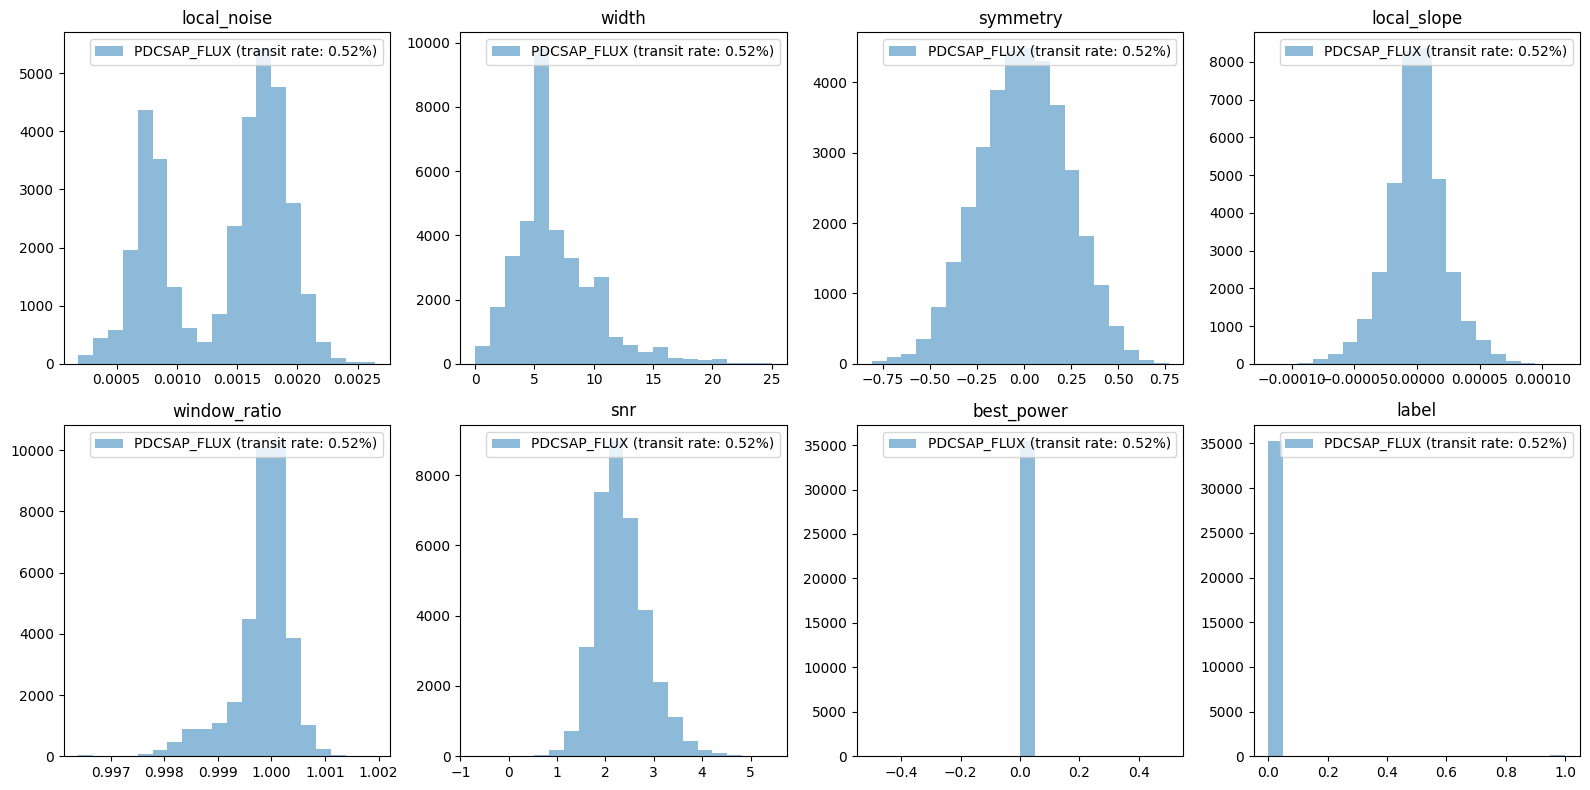

In [ ]:
# Visualize distribution differences between flux columns (if we have data)
if combined_df is not None and len(combined_df) > 0:
    # Get unique source files for each flux column type
    pdcsap_files = [f for f in combined_df['source_file'].unique() 
                   if 'PDCSAP_FLUX' in fits.open(f)[1].data.names]
    flux_files = [f for f in combined_df['source_file'].unique() 
                 if ('FLUX' in fits.open(f)[1].data.names and 
                     'PDCSAP_FLUX' not in fits.open(f)[1].data.names)]
    
    # Create masks for each flux type
    pdcsap_mask = combined_df['source_file'].isin(pdcsap_files)
    flux_mask = combined_df['source_file'].isin(flux_files)
    
    # Calculate transit detection rates
    pdcsap_transit_rate = combined_df[pdcsap_mask]['label'].mean() if pdcsap_mask.any() else 0
    flux_transit_rate = combined_df[flux_mask]['label'].mean() if flux_mask.any() else 0
    
    # Plot feature distributions by flux type
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    features = ["local_noise", "width", "symmetry", "local_slope", 
                "window_ratio", "snr", "best_power", "label"]
    
    for i, feature in enumerate(features):
        if pdcsap_mask.any():
            axes[i].hist(combined_df[pdcsap_mask][feature], bins=20, alpha=0.5, 
                        label=f'PDCSAP_FLUX (transit rate: {pdcsap_transit_rate:.2%})')
        if flux_mask.any():
            axes[i].hist(combined_df[flux_mask][feature], bins=20, alpha=0.5, 
                        label=f'FLUX (transit rate: {flux_transit_rate:.2%})')
        
        axes[i].set_title(feature)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Compare transit candidate features by flux type
    if pdcsap_mask.any() and flux_mask.any():
        transit_pdcsap = combined_df[pdcsap_mask & (combined_df['label'] == 1)]
        transit_flux = combined_df[flux_mask & (combined_df['label'] == 1)]
        
        if len(transit_pdcsap) > 0 and len(transit_flux) > 0:
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            
            # Plot SNR comparison
            axes[0].scatter(transit_pdcsap['snr'], transit_pdcsap['width'], 
                           alpha=0.7, label='PDCSAP_FLUX')
            axes[0].scatter(transit_flux['snr'], transit_flux['width'], 
                           alpha=0.7, label='FLUX')
            axes[0].set_xlabel('SNR')
            axes[0].set_ylabel('Width')
            axes[0].set_title('Transit Candidate Comparison')
            axes[0].legend()
            
            # Plot Symmetry vs Width
            axes[1].scatter(transit_pdcsap['symmetry'], transit_pdcsap['width'], 
                           alpha=0.7, label='PDCSAP_FLUX')
            axes[1].scatter(transit_flux['symmetry'], transit_flux['width'], 
                           alpha=0.7, label='FLUX')
            axes[1].set_xlabel('Symmetry')
            axes[1].set_ylabel('Width')
            axes[1].set_title('Transit Shape Comparison')
            axes[1].legend()
            
            # Plot local_noise vs SNR
            axes[2].scatter(transit_pdcsap['local_noise'], transit_pdcsap['snr'], 
                           alpha=0.7, label='PDCSAP_FLUX')
            axes[2].scatter(transit_flux['local_noise'], transit_flux['snr'], 
                           alpha=0.7, label='FLUX')
            axes[2].set_xlabel('Local Noise')
            axes[2].set_ylabel('SNR')
            axes[2].set_title('Transit Quality Comparison')
            axes[2].legend()
            
            plt.tight_layout()
            plt.show()

In [ ]:
# Continue to iterate?
if 'df' in locals() and len(df) > 0:
    print(f"Successfully created dataset with {len(df)} samples")
    
    # Save the dataset to avoid reprocessing files
    try:
        output_dir = "../../data/processed"
        os.makedirs(output_dir, exist_ok=True)
        output_file = f"{output_dir}/transit_features.csv"
        df.to_csv(output_file, index=False)
        print(f"Dataset saved to {output_file}")
    except Exception as e:
        print(f"Could not save dataset: {str(e)}")
        
    # Print some basic statistics
    print("\nFeature statistics:")
    print(df.describe())
    
    # Show class distribution
    print("\nClass distribution:")
    print(df.label.value_counts(normalize=True))
    
    # Feature distribution by class
    print("\nFeature means by class:")
    print(df.groupby('label').mean())
else:
    print("No valid data found. Please check the file paths and data processing steps.")

Successfully created dataset with 32136 samples
Dataset saved to ../../data/processed/transit_features.csv

Feature statistics:
        local_noise         width      symmetry   local_slope  window_ratio  \
count  32136.000000  32136.000000  32136.000000  3.213600e+04  32136.000000   
mean       0.001454      6.712596     -0.007439 -9.981755e-08      0.999823   
std        0.000533      3.924492      0.234757  2.361572e-05      0.000596   
min        0.000168      0.000000     -0.803500 -1.886293e-04      0.996862   
25%        0.000889      4.000000     -0.167743 -1.371647e-05      0.999571   
50%        0.001653      6.000000     -0.005435 -2.622493e-07      0.999878   
75%        0.001845      8.000000      0.155868  1.324910e-05      1.000110   
max        0.003046     40.000000      0.807419  2.276913e-04      1.004939   

                snr  best_power         label  
count  32136.000000     32136.0  32136.000000  
mean       2.358594         0.0      0.005943  
std        0.756

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
# ---- STEP 0: Select new feature set ----
if 'df' in locals() and len(df) > 0:
    X = df[["local_noise", "width", "symmetry", "local_slope",
            "window_ratio", "snr", "best_power"]]
    y = df["label"]

    unique_files = df['source_file'].unique()
    train_files, test_files = train_test_split(unique_files, test_size=0.3)

    # Split data based on source files
    train_mask = df['source_file'].isin(train_files)
    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[~train_mask], y[~train_mask]
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
else:
    print("No data available for model training.")

Training set: 29754 samples
Test set: 2382 samples


In [ ]:
# ---- STEP 2: Balance only the TRAIN set (optional if imbalanced) ----
if 'X_train' in locals() and len(X_train) > 0:
    if y_train.value_counts().min() < 0.5 * y_train.value_counts().max():
        train_df = X_train.copy()
        train_df["label"] = y_train

        majority = train_df[train_df.label == train_df.label.value_counts().idxmax()]
        minority = train_df[train_df.label != train_df.label.value_counts().idxmax()]

        minority_upsampled = resample(
            minority,
            replace=True,
            n_samples=len(majority),
            random_state=42
        )

        train_df = pd.concat([majority, minority_upsampled])
        X_train, y_train = train_df.drop("label", axis=1), train_df["label"]
        print(f"After balancing - Training set: {len(X_train)} samples")
        print(f"Class distribution: {y_train.value_counts()}")

    # ---- STEP 3: Pipeline (scaling + classifier) ----
    pipe = Pipeline([
        ("scaler", StandardScaler()),  
        ("clf", RandomForestClassifier(
            n_estimators=100,
            max_depth=3,
            min_samples_leaf=10,
            min_samples_split=10,
            class_weight='balanced',  # Added class weight to handle imbalance
            random_state=42
        ))
    ])

    # ---- STEP 4: Cross-validation on TRAIN set ----
    scores = cross_val_score(pipe, X_train, y_train, cv=5)
    print(f"Cross-validation accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

    # ---- STEP 5: Train final model ----
    pipe.fit(X_train, y_train)

    # ---- STEP 6: Evaluate on TEST set ----
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, y_pred))
else:
    print("Not enough data for training the model.")

After balancing - Training set: 59224 samples
Class distribution: label
0    29612
1    29612
Name: count, dtype: int64
Cross-validation accuracy: 0.998 ± 0.000
Cross-validation accuracy: 0.998 ± 0.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2333
           1       0.82      1.00      0.90        49

    accuracy                           1.00      2382
   macro avg       0.91      1.00      0.95      2382
weighted avg       1.00      1.00      1.00      2382

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2333
           1       0.82      1.00      0.90        49

    accuracy                           1.00      2382
   macro avg       0.91      1.00      0.95      2382
weighted avg       1.00      1.00      1.00      2382



In [ ]:
# ---- Neural Network for Transit Detection ----
if 'X_train' in locals() and len(X_train) > 0:
    try:
        from tensorflow import keras
        from keras import layers
        import tensorflow as tf
        from sklearn.metrics import confusion_matrix
        # Set random seed for reproducibility
        tf.random.set_seed(42)

        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Calculate class weights to handle imbalance
        # This gives more weight to the minority class (transits)
        class_weight = {
            0: 1.0,
            1: len(y_train[y_train == 0]) / len(y_train[y_train == 1]) if sum(y_train == 1) > 0 else 1.0
        }
        print(f"Class weights: {class_weight}")

        # Define the model architecture
        model = keras.Sequential([
            # Input layer with shape matching our features
            layers.Input(shape=(X_train.shape[1],)),
            
            # Hidden layers
            layers.Dense(16, activation='relu'),
            layers.Dropout(0.3),  # Prevent overfitting
            layers.Dense(8, activation='relu'),
            layers.Dropout(0.2),
            
            # Output layer - sigmoid for binary classification
            layers.Dense(1, activation='sigmoid')
        ])

        # Compile the model
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall'),
                     tf.keras.metrics.AUC(name='auc')]
        )

        # Print model summary
        model.summary()

        # Define callbacks for early stopping and model checkpoint
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        # Train the model
        history = model.fit(
            X_train_scaled, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            class_weight=class_weight,
            callbacks=[early_stopping],
            verbose=1
        )

        # Evaluate on TEST set
        # Get predictions (probabilities)
        y_pred_prob = model.predict(X_test_scaled)
        # Convert probabilities to binary predictions
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
        # Print classification report
        print("\nNeural Network Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot training history
        plt.figure(figsize=(12, 5))

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='lower right')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.tight_layout()
        plt.show()

        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Neural Network Confusion Matrix')
        plt.colorbar()
        tick_marks = [0, 1]
        plt.xticks(tick_marks, ['Non-Transit', 'Transit'])
        plt.yticks(tick_marks, ['Non-Transit', 'Transit'])

        # Add text annotations to the confusion matrix
        thresh = cm.max() / 2
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

        # Feature importance for neural networks requires a different approach
        # Let's plot precision-recall curve instead
        from sklearn.metrics import precision_recall_curve, auc

        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
        pr_auc = auc(recall, precision)

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.grid(True)
        plt.show()
        
        # Save the trained model
        try:
            models_dir = "../../models"
            os.makedirs(models_dir, exist_ok=True)
            
            # Save the Random Forest model
            import joblib
            joblib.dump(pipe, f"{models_dir}/random_forest_transit_detector.joblib")
            print(f"Random Forest model saved to {models_dir}/random_forest_transit_detector.joblib")
            
            # Save the Neural Network model
            model.save(f"{models_dir}/neural_network_transit_detector")
            print(f"Neural Network model saved to {models_dir}/neural_network_transit_detector")
            
            # Also save the scaler for preprocessing new data
            joblib.dump(scaler, f"{models_dir}/feature_scaler.joblib")
            print(f"Feature scaler saved to {models_dir}/feature_scaler.joblib")
        except Exception as e:
            print(f"Error saving models: {str(e)}")
            
    except ImportError as e:
        print(f"TensorFlow or Keras not available: {str(e)}")
        print("Skipping neural network training. Please install TensorFlow to use this feature.")
else:
    print("Not enough data for training the neural network model.")

Not enough data for training the neural network model.
